## Analysis scripts:
This script shows how to retrieve relavant data from an nwb file (both stored locally and streaming from DANDI).

1. Functions to retrive the cloud storage path for an nwb file stored in DANDI.

In [1]:
import pynwb
from pynwb import NWBHDF5IO
from nwbwidgets import nwb2widget
import requests
from dandi.dandiapi import DandiAPIClient

dandiset_id = "000121"
filepath = "sub-Reggie/sub-Reggie_ses-20170118T094022_behavior+ecephys.nwb"

with DandiAPIClient() as client:
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(filepath)
    s3_path = asset.get_content_url(follow_redirects=1, strip_query=True)

2. Open the nwb file:

In [74]:
# use the "Read Only S3" (ros3) driver to stream data directly from DANDI (or any other S3 location)
local_filepath = '/home/jovyan/shenoy/data/pr_npx_0323.nwb' 
io = NWBHDF5IO(local_filepath, mode='r', load_namespaces=True)
# io = NWBHDF5IO(s3_path, mode='r', load_namespaces=True, driver='ros3')
nwb = io.read()

/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.4.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [75]:
print(nwb.processing['ecephys'].data_interfaces.keys())

KeyError: 'ecephys'

## Visualization:
1. Position

available behavior variables: ['hand_position']


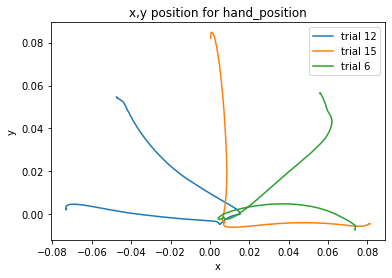

In [76]:
from nwbwidgets.behavior import route_spatial_series
from bisect import bisect
import plotly.graph_objects as go
import matplotlib.pyplot as plt

# retrieve all the spatial series ((x,y) position timeseries) stored in the nwb file:
spatial_series_dict = nwb.processing['behavior'].data_interfaces['Position'].spatial_series
names =  list(spatial_series_dict)
print(f'available behavior variables: {names}')
selected_name = names[0]

# get x,y data for a specific dataset:
spatial_series = spatial_series_dict[selected_name]
spatial_series_data = spatial_series.data
if spatial_series.timestamps is not None:
    spatial_series_timestamps = spatial_series.timestamps
else:
    spatial_series_timestamps = spatial_series.starting_time + np.arange(spatial_series.shape[0])/spatial_series.rate
    
#plot x,y trace for a specific trial no:
trial_nos = [12, 15, 6]
for trial_no in trial_nos:
    start_idx = bisect(spatial_series_timestamps, nwb.trials['start_time'][trial_no])
    end_idx = bisect(spatial_series_timestamps, nwb.trials['stop_time'][trial_no])
    # plot the x,y position:
    plt.plot(spatial_series_data[start_idx:end_idx,0], spatial_series_data[start_idx:end_idx,1], label = f'trial {trial_no}')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title(f'x,y position for {selected_name}')
plt.show()

In [5]:
#using nwbwidgets to plot:
# wid = route_spatial_series(spatial_series)
# wid

LFP pynwb.ecephys.LFP at 0x140384060171456
Fields:
  electrical_series: {
    M1_1 <class 'pynwb.ecephys.ElectricalSeries'>,
    PMd_1 <class 'pynwb.ecephys.ElectricalSeries'>
  }

2. Electrophysiology time series:

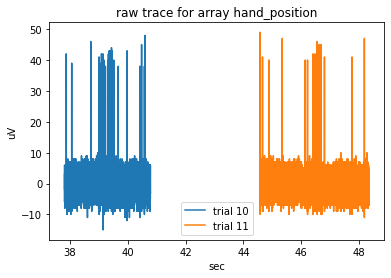

In [78]:
from nwbwidgets.ecephys import ElectricalSeriesWidget
import numpy as np
import matplotlib.pyplot as plt
from bisect import bisect

# LFP data stored:
if 'ecephys' in nwb.processing:
    eseries_name = list(nwb.processing['ecephys'].data_interfaces)[0]
    ephys_trace_dict = nwb.processing['ecephys'].data_interfaces[eseries_name].electrical_series
    # get data for a specific probe:
    names =  list(ephys_trace_dict)
    print(f'available behavior variables: {names}')
    selected_name = names[0]
    ephys_trace_container = ephys_trace_dict[selected_name]
else:
    # raw 30k Hz data:
    eseries_name = "raw"
    ephys_trace_container = nwb.acquisition['ElectricalSeries_raw']

ephys_data = ephys_trace_container.data
if ephys_trace_container.timestamps is not None:
    ephys_timestamps = ephys_trace_container.timestamps
else:
    ephys_timestamps = ephys_trace_container.starting_time + np.arange(ephys_data.shape[0])/ephys_trace_container.rate
    
#plot trace for a specific trial no:
trial_nos = np.arange(10,12)
electrode_no = np.arange(ephys_data.shape[1])[10]
for trial_no in trial_nos:
    start_idx = bisect(ephys_timestamps, nwb.trials['start_time'][trial_no])
    end_idx = bisect(ephys_timestamps, nwb.trials['stop_time'][trial_no])
    # plot trace:
    plt.plot(ephys_timestamps[start_idx:end_idx], ephys_data[start_idx:end_idx, electrode_no], label = f'trial {trial_no}')
plt.xlabel('sec')
plt.ylabel('uV')
plt.legend()
plt.title(f'{eseries_name} trace for array {selected_name}')
plt.show()

In [67]:
ElectricalSeriesWidget(ephys_trace_container)

ElectricalSeriesWidget(children=(GroupAndSortController(value={'order': array([ 0,  1,  2,  3,  4,  5,  6,  7,…

3. Getting trials metadata:

In [68]:
trials = nwb.trials
column_names = trials.colnames
print(column_names)

# can also convert to dataframe:
trials_df = trials.to_dataframe()

# retrieve specific column data:
stop_time=trials['stop_time'] # in seconds with respect to the session start time
start_time=trials['start_time']
print(start_time.description)

# for array like elements:
barrier_points=trials['barrier_points']
print(barrier_points[0].shape)
print(f'sample barrier point:{barrier_points[0]}')
print(barrier_points.target.description)

('start_time', 'stop_time', 'target_presentation_time', 'go_cue_time', 'reaction_time', 'move_begins_time', 'move_ends_time', 'discard_trial', 'task_success', 'trial_type', 'trial_version', 'proto_trial', 'maze_condition', 'correct_reach', 'maze_num_targets', 'maze_num_barriers', 'novel_maze', 'target_positions', 'frame_details', 'hit_target_position', 'target_size', 'barrier_info', 'timeseries')
Start time of epoch, in seconds


KeyError: 'barrier_points'

4. Retrieve units/clusters metadata and raster:

In [69]:
units = nwb.units
print(units.colnames, len(units))

# get spike timestamps for a specific unit
unit_no = 10
spike_times = units['spike_times'][unit_no]
spike_times.shape

('spike_times', 'obs_intervals', 'electrodes', 'electrode_group') 192


(302598,)

In [70]:
from nwbwidgets.misc import PSTHWidget, RasterWidget
PSTHWidget(nwb.units)

PSTHWidget(children=(HBox(children=(VBox(children=(GroupAndSortController(value={'order': array([   0,    1,  …